In [1]:
# import dependecies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.decomposition import PCA # research PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

In [2]:
# load datasets
data = pd.read_csv('personalFinanceDataset.csv')
syn = pd.read_csv('synData.csv')

In [3]:
data = data.drop('Unnamed: 0', axis=1)

In [4]:
targetColumn = 'financialHealth'

In [5]:
print('=' * 80)
print('DATASET COMPARISON DIAGNOSTICS')
print('=' * 80)

DATASET COMPARISON DIAGNOSTICS


In [6]:
print('\n1. BASIC DATASET STATISTICS')
print('=' * 80)
print('Original data shape:', data.shape)
print('Synthetic data shape:', syn.shape)
print('Original data columns:', list(data.columns))
print('Synthetic data columns:', list(syn.columns))


1. BASIC DATASET STATISTICS
Original data shape: (3500, 69)
Synthetic data shape: (3500, 69)
Original data columns: ['age', 'gender', 'raceEthnicity', 'education', 'region', 'householdType', 'householdSize', 'career', 'workArrangement', 'annualIncome', 'sideHustleIncome', 'monthlyIncome', 'housingStatus', 'housingCost', 'propertyTax', 'hoaFees', 'homeInsurance', 'utilities', 'internet', 'phone', 'ownsCar', 'carPayment', 'carInsurance', 'gas', 'publicTransit', 'carMaintenance', 'healthInsurance', 'oopMedical', 'dentalVision', 'lifeInsurance', 'studentLoans', 'ccPayment', 'personalLoans', 'medicalDebt', 'groceries', 'diningOut', 'coffee', 'alcohol', 'streaming', 'musicStreaming', 'gaming', 'gym', 'otherSubscriptions', 'clothing', 'personalCare', 'householdSupplies', 'childcare', 'petExpenses', 'entertainment', 'hobbies', 'travel', 'gifts', 'donations', 'retirement401k', 'iraContribution', 'emergencyFundContributions', 'generalSavings', 'investmentContributions', 'contributions529', 'tot

In [7]:
print('\n2. TARGET VARIABLE DISTRIBUTION COMPARISON')
print('-' * 80)


2. TARGET VARIABLE DISTRIBUTION COMPARISON
--------------------------------------------------------------------------------


In [8]:
ogTargetDist = data[targetColumn].value_counts().sort_index() # normalize makes the distribution percents vs numbers
synTargetDist = syn[targetColumn].value_counts().sort_index()

ogTargetProp = data[targetColumn].value_counts(normalize=True).sort_index()
synTargetProp = syn[targetColumn].value_counts(normalize=True).sort_index()

In [12]:
print('Original data target distribution', ogTargetProp)
print('Synthetic data target distribution', synTargetProp)

Original data target distribution financialHealth
FinanciallyDistressed    0.486857
FinanciallyStable        0.115143
FinanciallyThriving      0.031714
FinanciallyVulnerable    0.366286
Name: proportion, dtype: float64
Synthetic data target distribution financialHealth
FinanciallyDistressed    0.456571
FinanciallyStable        0.120571
FinanciallyThriving      0.056286
FinanciallyVulnerable    0.366571
Name: proportion, dtype: float64


In [10]:
print('\nAbsolute difference in class proportions:')
for label in ogTargetProp.index:
    dataProp = ogTargetProp.get(label, 0)
    synProp = synTargetProp.get(label, 0)
    print(f' Class {label}: {abs(dataProp - synProp):.2f}')


Absolute difference in class proportions:
 Class FinanciallyDistressed: 0.03
 Class FinanciallyStable: 0.01
 Class FinanciallyThriving: 0.02
 Class FinanciallyVulnerable: 0.00


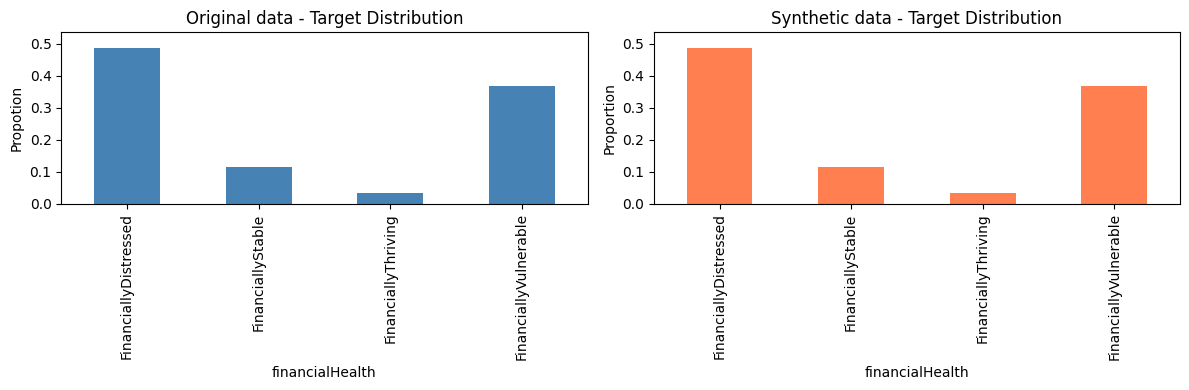

In [11]:
# visualize target distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ogTargetProp.plot(kind='bar', ax=ax1, color='steelblue')
ax1.set_title('Original data - Target Distribution')
ax1.set_ylabel('Propotion')
ax1.set_ylim([0, max(ogTargetProp.max(), synTargetProp.max()) * 1.1])

ogTargetProp.plot(kind='bar', ax=ax2, color='coral')
ax2.set_title('Synthetic data - Target Distribution')
ax2.set_ylabel('Proportion')
ax2.set_ylim([0, max(ogTargetProp.max(), synTargetProp.max()) * 1.1])
plt.tight_layout()

In [13]:
print('\n3. NUMERICAL FEATURES STATISTICAL COMPARISON')
print('-' * 80)


3. NUMERICAL FEATURES STATISTICAL COMPARISON
--------------------------------------------------------------------------------


In [16]:
# identify numerical columns
numericCols = data.select_dtypes('number').columns.tolist()

if len(numericCols) > 0:
    comparisons = pd.DataFrame()

for col in numericCols:
    ogMean = data[col].mean()
    ogStd = data[col].std()
    ogMin = data[col].min()
    ogMax = data[col].max()
    
    synMean = syn[col].mean()
    synStd = syn[col].std()
    synMin = syn[col].min()
    synMax = syn[col].max()
    
    # perform Kolmogorov-Smirnov test : 2 samples from same distribution? p-value > 0.05 = distributions similar
    ksStatistic, ksPvalue = stats.ks_2samp(
        data[col].dropna(),
        syn[col].dropna()
    )
    
    comparisons = pd.concat([comparisons, pd.DataFrame({
        'Feature': [col],
        'ogMean': [ogMean],
        'synMean': [synMean],
        'Mean Difference': [abs(ogMean - synMean)],
        'ogStd': [ogStd],
        'synStd': [synStd],
        'ogRange': [f'{ogMin:.2f} to {ogMax:.2f}'],
        'synRange': [f'{synMin:.2f} to {synMax:.2f}'],
        'ksStatistic': [ksStatistic],
        'ksPvalue': [ksPvalue]
        })], ignore_index=True)

huge huge huge metrics here; multiple top 10 features have largest mean differences.

In [15]:
comparisons.head()

,Feature,ogMean,synMean,Mean Difference,ogStd,synStd,ogRange,synRange,ksStatistic,ksPvalue
0,age,40.064286,45.315429,5.251143,12.041660,14.060070,25.00 to 70.00,23.00 to 79.00,0.212571,1.256539e-69
1,householdSize,2.455429,2.232000,0.223429,1.220250,1.062443,1.00 to 5.00,1.00 to 6.00,0.128286,1.659881e-25
2,annualIncome,59539.278108,35983.476798,23555.801310,33832.018375,23980.971833,12155.92 to 201295.13,-12310.92 to 178679.30,0.372571,1.460065e-216
3,sideHustleIncome,1546.698483,545.523905,1001.174578,3892.535837,2713.508204,0.00 to 32971.11,-607.29 to 36790.85,0.482857,0.000000e+00
4,monthlyIncome,5090.498049,5396.302800,305.804751,2918.055046,3507.714084,1012.99 to 18897.11,-241.38 to 19778.13,0.071143,4.002103e-08


In [ ]:
print('\n⚠️ Features with significantly different distributions (p < 0.01):') # changing considereing how small most p-values are
probFeatures = comparisons[comparisons['ksPvalue'] < 0.01]
if len(probFeatures) > 0:
    for _, row in probFeatures.iterrows():
        print(f'')